In [9]:
!git clone -b CatVTON https://github.com/Harsh-Kesharwani/stable-diffusion.git

Cloning into 'stable-diffusion'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 46 (delta 16), reused 38 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (46/46), 1.38 MiB | 22.07 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [10]:
cd stable-diffusion

/kaggle/working/stable-diffusion/stable-diffusion


In [11]:
ls

agnostic_mask.png  diffusion.py  interface.py        pipeline.py
attention.py       dog.jpg       merges.txt          README.md
clip.py            encoder.py    model_converter.py  requirements.txt
ddpm.py            garment.jpg   model.py            test.ipynb
decoder.py         image.png     person.jpg          vocab.json


In [12]:
# !wget https://huggingface.co/Envvi/Inkpunk-Diffusion/resolve/main/inkpunk-diffusion-v1.ckpt?download=true 

In [13]:
# mv 'inkpunk-diffusion-v1.ckpt?download=true' inkpunk-diffusion-v1.ckpt

In [14]:
!wget https://huggingface.co/sd-legacy/stable-diffusion-inpainting/resolve/main/sd-v1-5-inpainting.ckpt

--2025-06-08 17:04:34--  https://huggingface.co/sd-legacy/stable-diffusion-inpainting/resolve/main/sd-v1-5-inpainting.ckpt
Resolving huggingface.co (huggingface.co)... 3.163.189.90, 3.163.189.37, 3.163.189.74, ...
Connecting to huggingface.co (huggingface.co)|3.163.189.90|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: /stable-diffusion-v1-5/stable-diffusion-inpainting/resolve/main/sd-v1-5-inpainting.ckpt [following]
--2025-06-08 17:04:34--  https://huggingface.co/stable-diffusion-v1-5/stable-diffusion-inpainting/resolve/main/sd-v1-5-inpainting.ckpt
Reusing existing connection to huggingface.co:443.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/f6/56/f656f0fa3b8a40ac76d297fa2a4b00f981e8eb1261963460764e7dd3b35ec97f/c6bbc15e3224e6973459ba78de4998b80b50112b0ae5b5c67113d56b4e366b19?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27sd-v1-5-inpainting.ckpt%3B+filename%3D%22sd-v1-5-inpainting.ckp

In [15]:
!git pull

Already up to date.


In [ ]:
# !python diffusion.py

Input latent shape: torch.Size([1, 9, 64, 64])
Time embedding shape: torch.Size([1, 320])
Output shape: torch.Size([1, 4, 64, 64])


In [ ]:
import math
from typing import List, Union
import PIL
import torch
import numpy as np
from tqdm import tqdm
from ddpm import DDPMSampler
from PIL import Image
import model

WIDTH = 512
HEIGHT = 512
LATENTS_WIDTH = WIDTH // 8
LATENTS_HEIGHT = HEIGHT // 8

def repaint_result(result, person_image, mask_image):
    result, person, mask = np.array(result), np.array(person_image), np.array(mask_image)
    # expand the mask to 3 channels & to 0~1
    mask = np.expand_dims(mask, axis=2)
    mask = mask / 255.0
    # mask for result, ~mask for person
    result_ = result * mask + person * (1 - mask)
    return Image.fromarray(result_.astype(np.uint8))


def prepare_image(image):
    if isinstance(image, torch.Tensor):
        # Batch single image
        if image.ndim == 3:
            image = image.unsqueeze(0)
        image = image.to(dtype=torch.float32)
    else:
        # preprocess image
        if isinstance(image, (PIL.Image.Image, np.ndarray)):
            image = [image]
        if isinstance(image, list) and isinstance(image[0], PIL.Image.Image):
            image = [np.array(i.convert("RGB"))[None, :] for i in image]
            image = np.concatenate(image, axis=0)
        elif isinstance(image, list) and isinstance(image[0], np.ndarray):
            image = np.concatenate([i[None, :] for i in image], axis=0)
        image = image.transpose(0, 3, 1, 2)
        image = torch.from_numpy(image).to(dtype=torch.float32) / 127.5 - 1.0
    return image


def prepare_mask_image(mask_image):
    if isinstance(mask_image, torch.Tensor):
        if mask_image.ndim == 2:
            # Batch and add channel dim for single mask
            mask_image = mask_image.unsqueeze(0).unsqueeze(0)
        elif mask_image.ndim == 3 and mask_image.shape[0] == 1:
            # Single mask, the 0'th dimension is considered to be
            # the existing batch size of 1
            mask_image = mask_image.unsqueeze(0)
        elif mask_image.ndim == 3 and mask_image.shape[0] != 1:
            # Batch of mask, the 0'th dimension is considered to be
            # the batching dimension
            mask_image = mask_image.unsqueeze(1)

        # Binarize mask
        mask_image[mask_image < 0.5] = 0
        mask_image[mask_image >= 0.5] = 1
    else:
        # preprocess mask
        if isinstance(mask_image, (PIL.Image.Image, np.ndarray)):
            mask_image = [mask_image]

        if isinstance(mask_image, list) and isinstance(mask_image[0], PIL.Image.Image):
            mask_image = np.concatenate(
                [np.array(m.convert("L"))[None, None, :] for m in mask_image], axis=0
            )
            mask_image = mask_image.astype(np.float32) / 255.0
        elif isinstance(mask_image, list) and isinstance(mask_image[0], np.ndarray):
            mask_image = np.concatenate([m[None, None, :] for m in mask_image], axis=0)

        mask_image[mask_image < 0.5] = 0
        mask_image[mask_image >= 0.5] = 1
        mask_image = torch.from_numpy(mask_image)

    return mask_image


def numpy_to_pil(images):
    """
    Convert a numpy image or a batch of images to a PIL image.
    """
    if images.ndim == 3:
        images = images[None, ...]
    images = (images * 255).round().astype("uint8")
    if images.shape[-1] == 1:
        # special case for grayscale (single channel) images
        pil_images = [Image.fromarray(image.squeeze(), mode="L") for image in images]
    else:
        pil_images = [Image.fromarray(image) for image in images]

    return pil_images


def tensor_to_image(tensor: torch.Tensor):
    """
    Converts a torch tensor to PIL Image.
    """
    assert tensor.dim() == 3, "Input tensor should be 3-dimensional."
    assert tensor.dtype == torch.float32, "Input tensor should be float32."
    assert (
        tensor.min() >= 0 and tensor.max() <= 1
    ), "Input tensor should be in range [0, 1]."
    tensor = tensor.cpu()
    tensor = tensor * 255
    tensor = tensor.permute(1, 2, 0)
    tensor = tensor.numpy().astype(np.uint8)
    image = Image.fromarray(tensor)
    return image


def concat_images(images: List[Image.Image], divider: int = 4, cols: int = 4):
    """
    Concatenates images horizontally and with
    """
    widths = [image.size[0] for image in images]
    heights = [image.size[1] for image in images]
    total_width = cols * max(widths)
    total_width += divider * (cols - 1)
    # `col` images each row
    rows = math.ceil(len(images) / cols)
    total_height = max(heights) * rows
    # add divider between rows
    total_height += divider * (len(heights) // cols - 1)

    # all black image
    concat_image = Image.new("RGB", (total_width, total_height), (0, 0, 0))

    x_offset = 0
    y_offset = 0
    for i, image in enumerate(images):
        concat_image.paste(image, (x_offset, y_offset))
        x_offset += image.size[0] + divider
        if (i + 1) % cols == 0:
            x_offset = 0
            y_offset += image.size[1] + divider

    return concat_image

def resize_and_crop(image, size):
    # Crop to size ratio
    w, h = image.size
    target_w, target_h = size
    if w / h < target_w / target_h:
        new_w = w
        new_h = w * target_h // target_w
    else:
        new_h = h
        new_w = h * target_w // target_h
    image = image.crop(
        ((w - new_w) // 2, (h - new_h) // 2, (w + new_w) // 2, (h + new_h) // 2)
    )
    # resize
    image = image.resize(size, Image.LANCZOS)
    return image


def resize_and_padding(image, size):
    # Padding to size ratio
    w, h = image.size
    target_w, target_h = size
    if w / h < target_w / target_h:
        new_h = target_h
        new_w = w * target_h // h
    else:
        new_w = target_w
        new_h = h * target_w // w
    image = image.resize((new_w, new_h), Image.LANCZOS)
    # padding
    padding = Image.new("RGB", size, (255, 255, 255))
    padding.paste(image, ((target_w - new_w) // 2, (target_h - new_h) // 2))
    return padding

def check_inputs(image, condition_image, mask, width, height):
    if isinstance(image, torch.Tensor) and isinstance(condition_image, torch.Tensor) and isinstance(mask, torch.Tensor):
        return image, condition_image, mask
    assert image.size == mask.size, "Image and mask must have the same size"
    image = resize_and_crop(image, (width, height))
    mask = resize_and_crop(mask, (width, height))
    condition_image = resize_and_padding(condition_image, (width, height))
    return image, condition_image, mask


def compute_vae_encodings(image_tensor, encoder, device):
    """Encode image using VAE encoder"""
    # Generate random noise for encoding
    encoder_noise = torch.randn(
        (image_tensor.shape[0], 4, image_tensor.shape[2] // 8, image_tensor.shape[3] // 8),
        device=device,
    )
    
    # Encode using your custom encoder
    latent = encoder(image_tensor, encoder_noise)
    return latent


def generate(
    image: Union[PIL.Image.Image, torch.Tensor],
    condition_image: Union[PIL.Image.Image, torch.Tensor], 
    mask: Union[PIL.Image.Image, torch.Tensor],
    num_inference_steps: int = 50,
    guidance_scale: float = 2.5,
    height: int = 1024,
    width: int = 768,
    models={},
    sampler_name="ddpm",
    seed=None,
    device=None,
    idle_device=None,
    **kwargs
):
    with torch.no_grad():
        if idle_device:
            to_idle = lambda x: x.to(idle_device)
        else:
            to_idle = lambda x: x

        # Initialize random number generator according to the seed specified
        generator = torch.Generator(device=device)
        if seed is None:
            generator.seed()
        else:
            generator.manual_seed(seed)

        concat_dim = -1  # FIXME: y axis concat

        # Prepare inputs to Tensor
        image, condition_image, mask = check_inputs(image, condition_image, mask, width, height)
        # print(f"Input image shape: {image.shape}, condition image shape: {condition_image.shape}, mask shape: {mask.shape}")
        image = prepare_image(image).to(device)
        condition_image = prepare_image(condition_image).to(device)
        mask = prepare_mask_image(mask).to(device)

        print(f"Prepared image shape: {image.shape}, condition image shape: {condition_image.shape}, mask shape: {mask.shape}")
        # Mask image
        masked_image = image * (mask < 0.5)

        print(f"Masked image shape: {masked_image.shape}")

        # VAE encoding
        encoder = models.get('encoder', None)
        if encoder is None:
            raise ValueError("Encoder model not found in models dictionary")
        
        encoder.to(device)
        masked_latent = compute_vae_encodings(masked_image, encoder, device)
        condition_latent = compute_vae_encodings(condition_image, encoder, device)
        to_idle(encoder)

        print(f"Masked latent shape: {masked_latent.shape}, condition latent shape: {condition_latent.shape}")

        # Concatenate latents
        masked_latent_concat = torch.cat([masked_latent, condition_latent], dim=concat_dim)

        print(f"Masked Person latent + garment latent: {masked_latent_concat.shape}")

        mask_latent = torch.nn.functional.interpolate(mask, size=masked_latent.shape[-2:], mode="nearest")
        del image, mask, condition_image
        mask_latent_concat = torch.cat([mask_latent, torch.zeros_like(mask_latent)], dim=concat_dim)

        print(f"Mask latent concat shape: {mask_latent_concat.shape}")
        
        # Initialize latents
        latents = torch.randn(
            masked_latent_concat.shape,
            generator=generator,
            device=masked_latent_concat.device,
            dtype=masked_latent_concat.dtype
        )

        print(f"Latents shape: {latents.shape}")
        
        # Prepare timesteps
        if sampler_name == "ddpm":
            sampler = DDPMSampler(generator)
            sampler.set_inference_timesteps(num_inference_steps)
        else:
            raise ValueError("Unknown sampler value %s. " % sampler_name)

        timesteps = sampler.timesteps
        # latents = sampler.add_noise(latents, timesteps[0])
        
        # Classifier-Free Guidance
        do_classifier_free_guidance = guidance_scale > 1.0
        if do_classifier_free_guidance:
            masked_latent_concat = torch.cat(
                [
                    torch.cat([masked_latent, torch.zeros_like(condition_latent)], dim=concat_dim),
                    masked_latent_concat,
                ]
            )
            mask_latent_concat = torch.cat([mask_latent_concat] * 2)

            print(f"Masked latent concat for classifier-free guidance: {masked_latent_concat.shape}, mask latent concat: {mask_latent_concat.shape}")
        

        # Denoising loop - Fixed: removed self references and incorrect scheduler calls
        num_warmup_steps = 0  # For simple DDPM, no warmup needed
        
        with tqdm(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # expand the latents if we are doing classifier free guidance
                non_inpainting_latent_model_input = (torch.cat([latents] * 2) if do_classifier_free_guidance else latents)

                # print(f"Non-inpainting latent model input shape: {non_inpainting_latent_model_input.shape}")
                
                # prepare the input for the inpainting model
                inpainting_latent_model_input = torch.cat([non_inpainting_latent_model_input, mask_latent_concat, masked_latent_concat], dim=1)

                # print(f"Inpainting latent model input shape: {inpainting_latent_model_input.shape}")
                
                # predict the noise residual
                diffusion = models.get('diffusion', None)
                if diffusion is None:
                    raise ValueError("Diffusion model not found in models dictionary")
                
                diffusion.to(device)
                
                # Create time embedding for the current timestep
                time_embedding = get_time_embedding(t.item()).to(device)
                # print(f"Time embedding shape: {time_embedding.shape}")

                if do_classifier_free_guidance:
                    time_embedding = torch.cat([time_embedding] * 2)
                
                noise_pred = diffusion(
                    inpainting_latent_model_input,
                    time_embedding
                )
                
                to_idle(diffusion)
                
                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (
                        noise_pred_text - noise_pred_uncond
                    )
                
                # compute the previous noisy sample x_t -> x_t-1
                latents = sampler.step(t, latents, noise_pred)
                
                # Update progress bar
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps):
                    progress_bar.update()

        # Decode the final latents
        latents = latents.split(latents.shape[concat_dim] // 2, dim=concat_dim)[0]

        decoder = models.get('decoder', None)
        if decoder is None:
            raise ValueError("Decoder model not found in models dictionary")
        
        decoder.to(device)

        image = decoder(latents.to(device))
        # image = rescale(image, (-1, 1), (0, 255), clamp=True)
        image = (image / 2 + 0.5).clamp(0, 1)
        # we always cast to float32 as this does not cause significant overhead and is compatible with bfloat16
        image = image.cpu().permute(0, 2, 3, 1).float().numpy()
        image = numpy_to_pil(image)
        
        to_idle(decoder)
        
        return image
    

def rescale(x, old_range, new_range, clamp=False):
    old_min, old_max = old_range
    new_min, new_max = new_range
    x -= old_min
    x *= (new_max - new_min) / (old_max - old_min)
    x += new_min
    if clamp:
        x = x.clamp(new_min, new_max)
    return x

def get_time_embedding(timestep):
    # Shape: (160,)
    freqs = torch.pow(10000, -torch.arange(start=0, end=160, dtype=torch.float32) / 160) 
    # Shape: (1, 160)
    x = torch.tensor([timestep], dtype=torch.float32)[:, None] * freqs[None]
    # Shape: (1, 160 * 2) -> (1, 320)
    return torch.cat([torch.cos(x), torch.sin(x)], dim=-1)

if __name__ == "__main__":
    # Example usage
    image = Image.open("sample_dataset/image.png").convert("RGB")
    condition_image = Image.open("sample_dataset/cloth.png").convert("RGB")
    mask = Image.open("sample_dataset/agnostic_mask.png").convert("L")

    # Load models
    models=model.preload_models_from_standard_weights(ckpt_path="sd-v1-5-inpainting.ckpt", device="cuda", finetune_weight_path="model.safetensors")

    # Generate image
    generated_image = generate(
        image=image,
        condition_image=condition_image,
        mask=mask,
        num_inference_steps=50,
        guidance_scale=2.5,
        width=WIDTH,
        height=HEIGHT,
        models=models,
        sampler_name="ddpm",
        seed=42,    
        device="cuda"  # or "cpu"
    )

    generated_image[0].save("generated_image.png")
    

ModuleNotFoundError: No module named 'ddpm'

In [19]:
ls

agnostic_mask.png  garment.jpg          pipeline.py
attention.py       generated_image.png  README.md
clip.py            image.png            requirements.txt
ddpm.py            interface.py         sd-v1-5-inpainting.ckpt
decoder.py         merges.txt           test.ipynb
diffusion.py       model_converter.py   vocab.json
dog.jpg            model.py
encoder.py         person.jpg


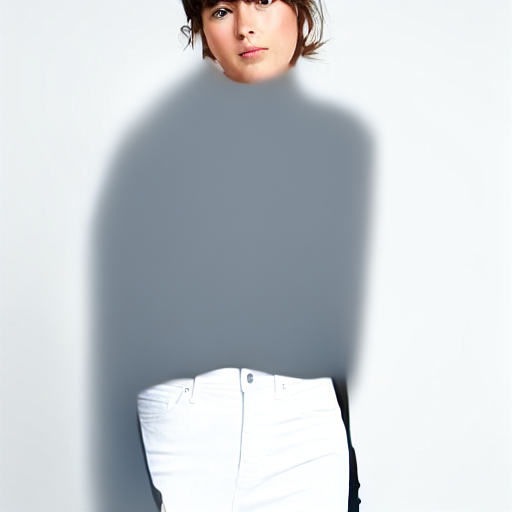

In [20]:
from IPython.display import display

display(generated_image[0])

In [11]:
total_params = 0
for name, model_obj in models.items():
    if hasattr(model_obj, 'parameters'):
        params = sum(p.numel() for p in model_obj.parameters() if p.requires_grad)
        print(f"{name}: {params / 1e6:.2f}M trainable parameters")
        total_params += params
print(f"Total trainable parameters: {total_params / 1e6:.2f}M")


clip: 123.06M trainable parameters
encoder: 34.16M trainable parameters
decoder: 49.49M trainable parameters
diffusion: 815.57M trainable parameters
Total trainable parameters: 1022.29M


In [7]:
import torch
import gc

# Delete all tensors and force garbage collection
torch.cuda.empty_cache()           # Clears unused memory
gc.collect()                       # Python garbage collection

# If you want to delete specific variables:
for obj in dir():
    if 'cuda' in str(locals()[obj]):
        del locals()[obj]
gc.collect()
torch.cuda.empty_cache()
